## Import Data ##

In [100]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
from scipy.stats import *
import time
from skimage.transform import resize
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [106]:
df = pd.read_csv("/Users/jay/Jupyter Projects/Torch/Quran/files_paths.csv")
df

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan
...,...,...
6682,./Dataset/Abdullah_Albuaijan/Abdullah_148.wav,Abdullah_Albuaijan
6683,./Dataset/Abdullah_Albuaijan/Abdullah_014.wav,Abdullah_Albuaijan
6684,./Dataset/Abdullah_Albuaijan/Abdullah_028.wav,Abdullah_Albuaijan
6685,./Dataset/Abdullah_Albuaijan/Abdullah_202.wav,Abdullah_Albuaijan


In [108]:
#If ./ in front of file path then edit the path

df["FilePath"] = "/Users/jay/Jupyter Projects/Torch/Quran/Dataset" + df["FilePath"].str[1:]
df["FilePath"].iloc[1]

'/Users/jay/Jupyter Projects/Torch/Quran/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_159.wav'

Shape:  (6687, 2)

Counts:
 Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Maher_Almuaiqly         576
Bander_Balilah          576
Ali_Alhothaify          576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64



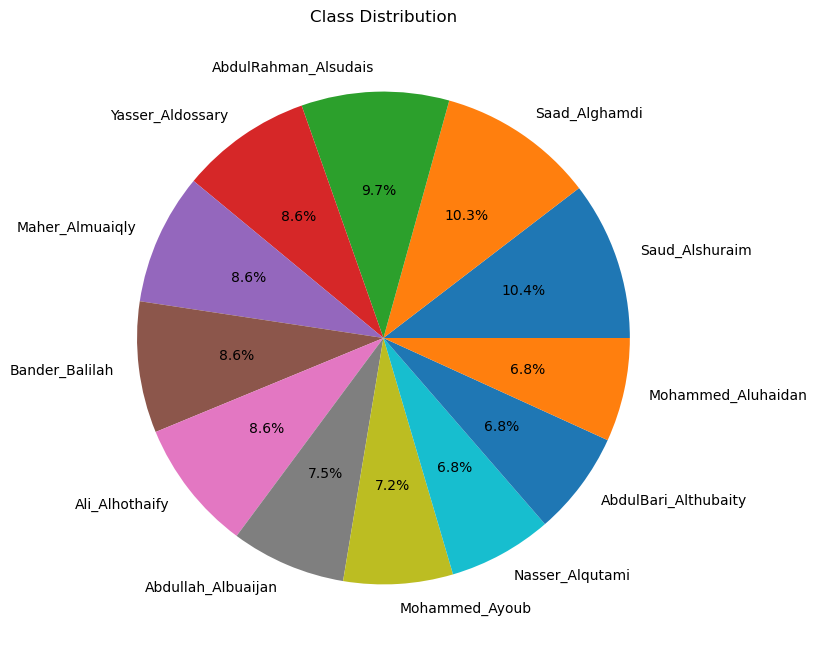

In [130]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["Class"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["Class"].value_counts(), labels = df["Class"].value_counts().index, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.show()

## Training Model ##

In [149]:
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])

train = df.sample(frac = 0.7, random_state = 7)
test = df.drop(train.index)

val = test.sample(frac = 0.5, random_state = 7)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(4681, 2)
(1003, 2)
(1003, 2)


In [155]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe["FilePath"]]
        
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label

    def get_spectrogram(self, file_path):
        sr = 22050
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr = sr, duration = duration)
        spec = librosa.feature.melspectrogram(y = signal, sr = sr, n_fft=2048, hop_length = 512, n_mels = 128)
        spec_db = librosa.power_to_db(spec, ref = np.max)

        spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr) // 512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [157]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

In [159]:
lr = 1e-4
batch_size = 16
EPOCHS = 25

In [202]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [212]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64*16*32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)

        self.output = nn.Linear(512, len(df["Class"].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        
        x = self.conv2(x)
        x = self.pooling(x)
        
        x = self.conv3(x)
        x = self.pooling(x)
        
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        
        x = self.flatten(x)
        
        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

In [214]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [216]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = lr)

In [220]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/100, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/100, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/25 
    Training Loss: 0.1988 
    Training Accuracy: 98.825 
    Validation Loss: 0.373 
    Validation Accuracy: 94.1176
Epoch no. 2/25 
    Training Loss: 0.5289 
    Training Accuracy: 97.2869 
    Validation Loss: 0.2835 
    Validation Accuracy: 95.2144
Epoch no. 3/25 
    Training Loss: 0.207 
    Training Accuracy: 98.6755 
    Validation Loss: 0.228 
    Validation Accuracy: 95.9123
Epoch no. 4/25 
    Training Loss: 0.167 
    Training Accuracy: 99.0814 
    Validation Loss: 0.3068 
    Validation Accuracy: 94.5165
Epoch no. 5/25 
    Training Loss: 0.2541 
    Training Accuracy: 98.6541 
    Validation Loss: 0.3647 
    Validation Accuracy: 94.0179
Epoch no. 6/25 
    Training Loss: 0.1519 
    Training Accuracy: 99.1241 
    Validation Loss: 0.5743 
    Validation Accuracy: 92.9212
Epoch no. 7/25 
    Training Loss: 0.5592 
    Training Accuracy: 97.8423 
    Validation Loss: 0.3284 
    Validation Accuracy: 94.6162
Epoch no. 8/25 
    Training Loss: 0.2002 
   

In [238]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 95.015 
Loss: 0.0


## Post-Training Analysis ##

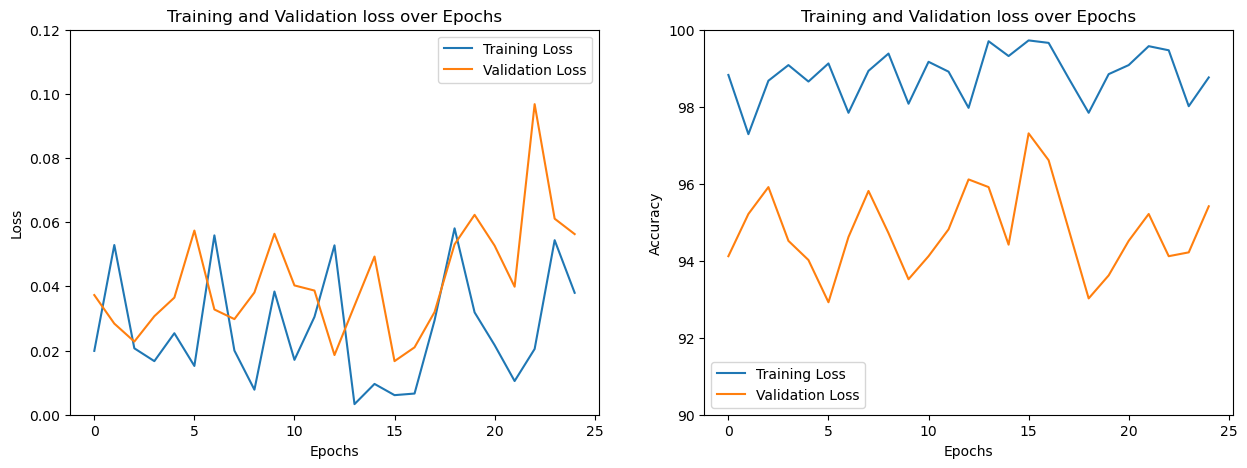

In [246]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.12])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([90,100])
axs[1].legend()

plt.show()

In [254]:
torch.save(model.state_dict(), "Quran.pth")

In [256]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("Quran.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)